In [14]:
import numpy as np
import math
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

#change 1

In [15]:
wavelength = 0.1542 #nm
lattice_constant = 0.5949 #nm

In [16]:
# All of the allowed reflections for the FCC crystal structure are:
miller_indices = np.array([
    [1, 1, 1],
    [2, 0, 0],
    [2, 2, 0],
    [3, 1, 1],
    [2, 2, 2],
    [4, 0, 0],
    [3, 3, 1],
    [4, 2, 0],
    [4, 2, 2]
])
miller_list = [list(row) for row in miller_indices]
df = pd.DataFrame({'Miller': miller_list})

In [17]:
df['hkl_squared'] = df['Miller'].apply(lambda x: x[0]**2 + x[1]**2 + x[2]**2)
df['sin theta (rad)'] = df['hkl_squared'].apply(lambda x: math.sqrt((wavelength**2/(4*lattice_constant**2))*x))
df['theta (rad)'] = df['sin theta (rad)'].apply(lambda x:(math.asin(x)))
df['theta (deg)'] = df['theta (rad)'].apply(lambda x: np.rad2deg(x))
df['2 theta (deg)'] = df['theta (deg)'].apply(lambda x: 2 * x)

In [18]:
df

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg)
0,"[1, 1, 1]",3,0.224477,0.226406,12.972101,25.944202
1,"[2, 0, 0]",4,0.259203,0.262197,15.022790,30.045579
2,"[2, 2, 0]",8,0.366569,0.375318,21.504156,43.008313
3,"[3, 1, 1]",11,0.429840,0.444315,25.457402,50.914804
4,"[2, 2, 2]",12,0.448953,0.465593,26.676540,53.353079
5,"[4, 0, 0]",16,0.518406,0.544986,31.225420,62.450840
6,"[3, 3, 1]",19,0.564920,0.600337,34.396760,68.793519
7,"[4, 2, 0]",20,0.579596,0.618233,35.422135,70.844270
8,"[4, 2, 2]",24,0.634916,0.687899,39.413728,78.827457


In [19]:
# Define atom positons in cubic cell:
Al_positions = np.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.0], [0.5, 0.0, 0.5], [0.0, 0.5, 0.5]])
Cu_positions = np.array([[0.25, 0.25, 0.25], [0.75, 0.25, 0.25], [0.25, 0.25, 0.75], [0.75, 0.25, 0.75], [0.25, 0.75, 0.75], [0.75, 0.75, 0.75], [0.25, 0.75, 0.25], [0.75, 0.75, 0.25]])
Mn_positions = np.array([[0.5, 0.5, 0.5], [1.0, 0.5, 1.0], [0.5, 1, 1], [1.0, 1.0, 0.5]]) # are these correct? 
#Mn_positions = np.array([[0.5, 0.5, 0.5], [0, 0, 0.5], [0.5, 0, 1], [0, 0.5, 1]])
# may be try different posiitons

In [20]:
# This calculates the term that will be multiplied by the atomic scattering factor
# for each atom type and for each miller incices
def compute_structure_factor_term(atom_positions, miller_indices_array):
    results = {}
    
    for miller_indices in miller_indices_array:
        h, k, l = miller_indices
        total = 0
        
        for position in atom_positions:
            position_adjusted = 2*position # distribute the 2 in the exponential factor to each atom position
            x, y, z = position_adjusted
            value = x * h + y * k + z * l

            # Check if value is even or 0
            if value % 2 == 0:
                total += 1
            # If value is odd
            else:
                total -= 1
        
        # Store the result with Miller indices as the key
        results[tuple(miller_indices)] = total
    
    return results

In [21]:
Al_structure_factor_term = compute_structure_factor_term(Al_positions, miller_indices)
Cu_structure_factor_term = compute_structure_factor_term(Cu_positions, miller_indices)
Mn_structure_factor_term = compute_structure_factor_term(Mn_positions, miller_indices)
print("Al", Al_structure_factor_term)
print("Cu", Cu_structure_factor_term)
print("Mn",Mn_structure_factor_term)

Al {(1, 1, 1): 4, (2, 0, 0): 4, (2, 2, 0): 4, (3, 1, 1): 4, (2, 2, 2): 4, (4, 0, 0): 4, (3, 3, 1): 4, (4, 2, 0): 4, (4, 2, 2): 4}
Cu {(1, 1, 1): -8, (2, 0, 0): -8, (2, 2, 0): 8, (3, 1, 1): -8, (2, 2, 2): -8, (4, 0, 0): 8, (3, 3, 1): -8, (4, 2, 0): -8, (4, 2, 2): 8}
Mn {(1, 1, 1): -4, (2, 0, 0): 4, (2, 2, 0): 4, (3, 1, 1): -4, (2, 2, 2): 4, (4, 0, 0): 4, (3, 3, 1): -4, (4, 2, 0): 4, (4, 2, 2): 4}


In [22]:
# This calculates f, the atomic scattering factor, for each atom time at each theta angle 
# check the angle calculation units
def calc_atomic_scattering_factor(theta, atomic_number, a1, b1, a2, b2, a3, b3, a4=None, b4=None, wavelength = 0.1542):
    s = math.sin(theta)/(wavelength*10)
    f = atomic_number - (41.78214 * s**2) * (a1*np.e**(-b1*s**2) + a2*np.e**(-b2*s**2) + a3*np.e**(-b3*s**2) + a4*np.e**(-b4*s**2))
    return f

In [23]:
# Populate df with atomic scattering factors
df['Al_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 13, 2.276, 72.322, 2.428, 19.773, 0.858, 3.080, 0.317, 0.408))
df['Cu_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 29, 1.579, 62.940, 1.820, 12.453, 1.658, 2.504, 0.532, 0.333))
df['Mn_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 25, 2.747, 67.786, 2.456, 15.674, 1.792, 3, 0.498, 0.357))

In [27]:
# Calculate the structure factors using the atomic scattering factors- 
# i need to go through this math to make sure it is correct- 
# it definitely doesnt match the peak intensities given on mateirals project
df['Structure Factor'] = (df['Al_f'] * df['Miller'].apply(lambda x: Al_structure_factor_term[tuple(x)]) +
                              df['Cu_f'] * df['Miller'].apply(lambda x: Cu_structure_factor_term[tuple(x)]) +
                              df['Mn_f'] * df['Miller'].apply(lambda x: Mn_structure_factor_term[tuple(x)]))
df['F^2'] = df['Structure Factor']**2
df['p'] = [8, 6, 12, 24, 8, 6, 24, 24, 24]
df['Lorentz_factor'] = df['theta (rad)'].apply(lambda x: (1+(math.cos(2*x)**2) / (math.sin(x)**2 * math.cos(x))))
df['Intensity'] = df['F^2']*df['p']*df['Lorentz_factor']
df["Intensity_norm"] = (df["Intensity"]/df["Intensity"].max())*100


In [28]:
df

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg),Al_f,Cu_f,Mn_f,Structure Factor,F^2,p,angle_factor,Intensity,Intensity_norm,Lorentz_factor
0,"[1, 1, 1]",3,0.224477,0.226406,12.972101,25.944202,10.160856,25.533969,20.935051,-247.368531,61191.190044,8,17.467120,8.550671e+06,100.000000,17.467120
1,"[2, 0, 0]",4,0.259203,0.262197,15.022790,30.045579,9.713868,24.727892,20.134569,-78.429389,6151.169084,6,12.547386,4.630866e+05,5.415792,12.547386
2,"[2, 2, 0]",8,0.366569,0.375318,21.504156,43.008313,8.600670,22.136560,17.743943,282.470933,79789.827740,12,5.277215,5.052817e+06,59.092639,5.277215
3,"[3, 1, 1]",11,0.429840,0.444315,25.457402,50.914804,8.087463,20.601965,16.414216,-198.122739,39252.619638,24,3.382761,3.186774e+06,37.269282,3.382761
4,"[2, 2, 2]",12,0.448953,0.465593,26.676540,53.353079,7.948357,20.148922,16.032245,-65.268968,4260.038132,8,2.978125,1.014954e+05,1.186987,2.978125
5,"[4, 0, 0]",16,0.518406,0.544986,31.225420,62.450840,7.479801,18.571004,14.733662,237.421890,56369.153627,6,1.930821,6.530325e+05,7.637207,1.930821
6,"[3, 3, 1]",19,0.564920,0.600337,34.396760,68.793519,7.175614,17.582593,13.937488,-167.708238,28126.053256,24,1.496895,1.010442e+06,11.817103,1.496895
7,"[4, 2, 0]",20,0.579596,0.618233,35.422135,70.844270,7.078085,17.282138,13.696681,-55.158036,3042.408926,24,1.393326,1.017376e+05,1.189820,1.393326
8,"[4, 2, 2]",24,0.634916,0.687899,39.413728,78.827457,6.696942,16.195080,12.825979,207.652320,43119.486128,24,1.120551,1.159622e+06,13.561767,1.120551


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

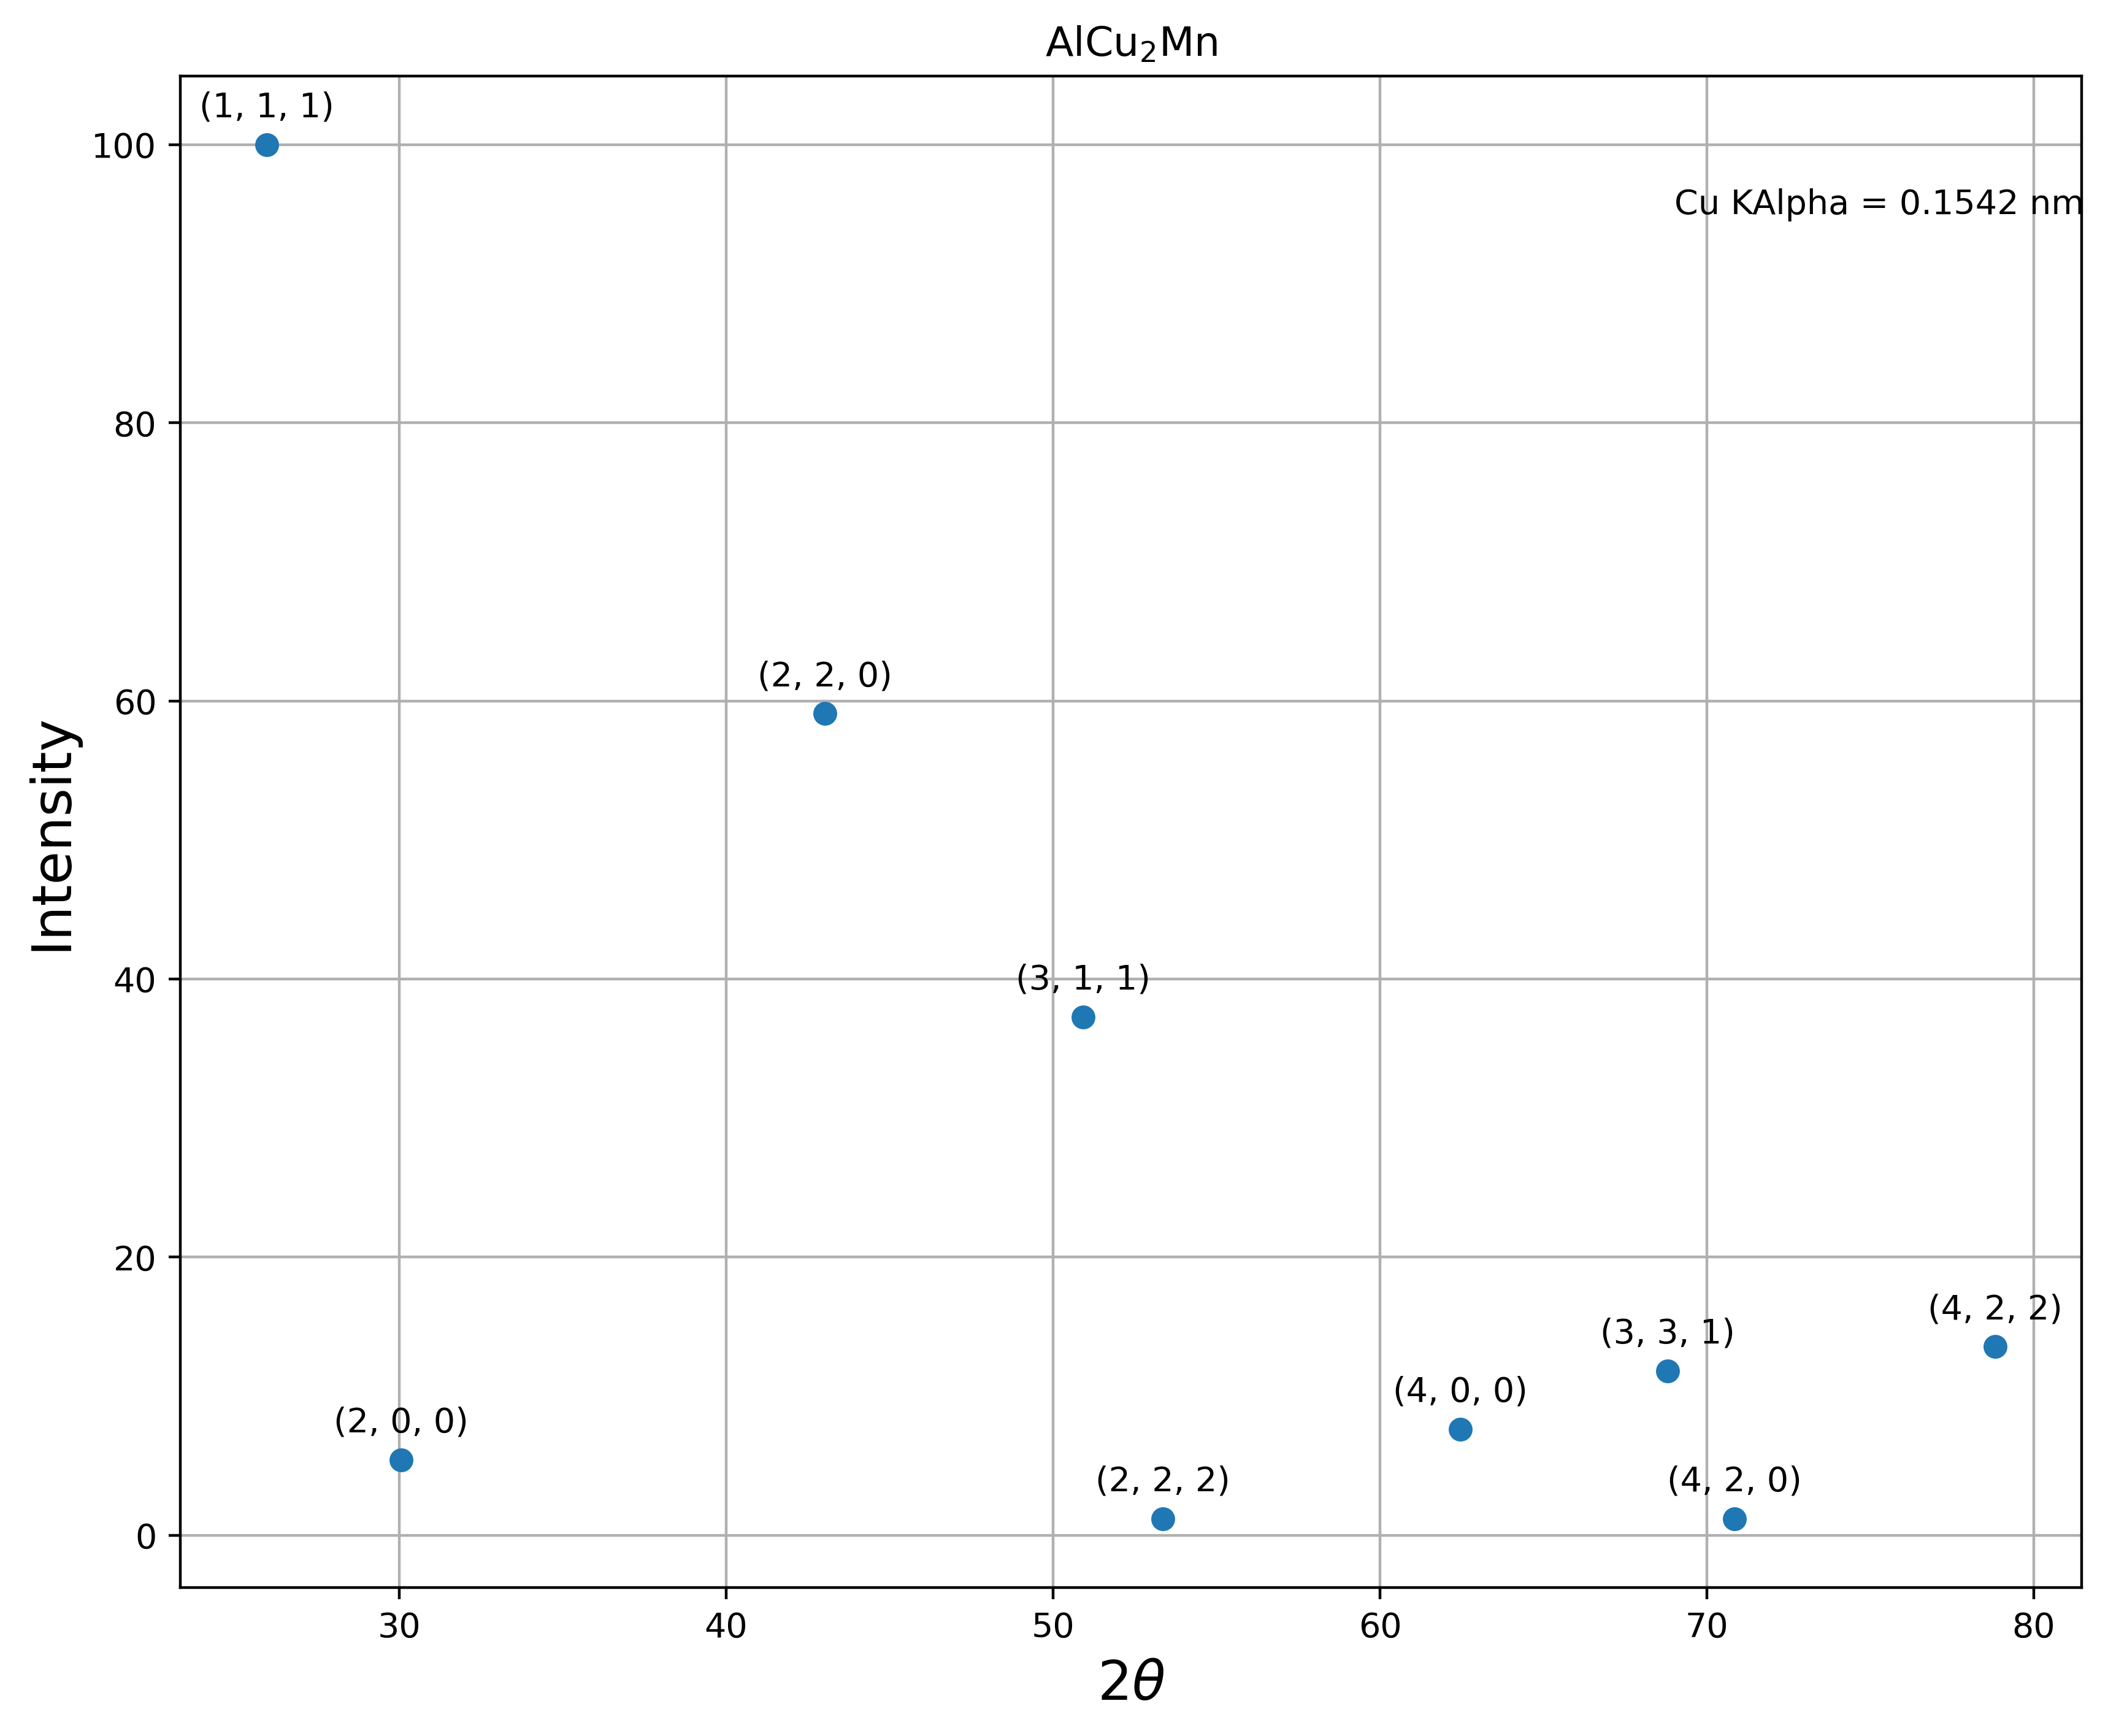

In [29]:
fig = plt.figure(figsize=(10, 8), dpi = 400)
plt.plot(df['2 theta (deg)'], df['Intensity_norm'], 'o')

# Add text labels above each data point
for index, row in df.iterrows():
    label = str(row['Miller']).replace('[', '(').replace(']', ')')
    x = row['2 theta (deg)']
    y = row['Intensity_norm']
    plt.text(x, y + 0.02 * max(df['Intensity_norm']), label, ha='center')

# Figure formatting
plt.text(69, 95, "Cu KAlpha = 0.1542 nm")
plt.xlabel("2"r'$\theta$', fontsize = 16)
plt.ylabel('Intensity', fontsize = 16)
plt.title(r'$\mathrm{AlCu_2Mn}$')
plt.grid()
plt.tight_layout
